# TransposonRead_Profile_Compare.py

## Introduction
One of the most important visual results of the analysis of SATAY data is a plot that show the number of transposon insertions and the number of reads per location in the genome.
This script visualizes this using a bar plot for each individual chromosome.
These plots can also be useful for visualy comparing two datasets with each other as these bar plots can show deviations between two datasets.

This notebook includes two functions that are closely related to the functions in TransposonRead_Profile_Plot.py, but is altered to automatically show two datasets with each other and show the differences between the two.
One function is to show the location of transposon insertions and the second function shows the number of reads for each transposon insertion.

This can be used as a initial visual check for large differences between two datasets in terms of transposon insertion locations and number of reads per transposon.

Below are the packages that needs to be loaded for both functions.

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

file_dirname = os.path.dirname(os.path.abspath('__file__'))
sys.path.insert(1,os.path.join(file_dirname,'python_modules'))
from chromosome_and_gene_positions import chromosome_position, chromosomename_roman_to_arabic, gene_position
from essential_genes_names import list_known_essentials
from gene_names import gene_aliases
from chromosome_names_in_files import chromosome_name_bedfile, chromosome_name_wigfile

## The python script for comparing transposon insertion locations

This function creates a bar plot with the number of transposons in a chromosome. The background of the bar plot has colored regions that indicate the locations of the genes. Green regions indicate annotated essential genes and red regions are the genes not annotated as essential. The names of the essential genes are given as well.

This graph can be used to check how well the transposon data corresponds with the location of essential genes, where only few transposon insertions are expected, which can be directly compared between two datasets.

### Input
The function inputs the path to a bed file (`bed_file`, type=string) which is created by the Matlab code provided from the Kornman lab [https://sites.google.com/site/satayusers/complete-protocol/bioinformatics-analysis/matlab-script].
Next it inputs the chromosome number given as a roman numeral (`chrom_user_set`, type=string, list of strings or None-type, default=`None`).
When `chrom_user_set` is not given or set a None, the scripts automatically considers all chromosomes.
When a list of chromosomes is given, it considers all chromosomes given in the list.
The bar width that indicates the width of the final bar plot (`bar_width`, type=int, default=chromosome length divided by 500).
The `bar_width` variable takes as default value the length of the chromosome and divides this N bins or equal length.
When both `savefigure_path` (type=string, default=`None`) and `savefigure_name` (type=string, default=`None`) are given, the scripts automatically saves all figures to the given location and adds the extension `_chromX` where `X` is changed to the respective chromosome number.

If either one of the two are not given or set to None, the figures won't be saved.

In [3]:
bed_files = [os.path.join(file_dirname,'..','satay_analysis_testdata','Output_Processing','Cerevisiae_WT2_Michel2017_trimmed1.bam.bed'),
os.path.join(file_dirname,'..','satay_analysis_testdata','Output_Processing','Cerevisiae_WT2_Michel2017_trimmed2.bam.bed')] #CHANGE THIS TO ANY .BED FILES YOU WANT TO ANALYSE.
chrom_user_set = 'I'
bar_width_user_set=None
savefigure_path=None
savefigure_name=None

### Loading additional files
Next additional files are loaded. Change these to your local paths leading to the gff-file (for example downloaded from SGD [https://www.yeastgenome.org/] or get a copy from the docs folder on Github [https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis]) and yeast_protein_Names file.
Also two lists of essential genes are loaded. Some essential genes are present only in a single file, hence both files are used simultenously.

In [4]:
gff_file = os.path.join(file_dirname,'Data_Files','Saccharomyces_cerevisiae.R64-1-1.99.gff3')
essential_genes_files = [os.path.join(file_dirname,'Data_Files','Cervisiae_EssentialGenes_List_1.txt'),
                        os.path.join(file_dirname,'Data_Files','Cervisiae_EssentialGenes_List_2.txt')]
gene_information_file = os.path.join(file_dirname,'Data_Files','Yeast_Protein_Names.txt')

### Get chromosome length and essential genes

Determine the length and position of all chromosomes and get a list of all genes, all essential genes and the aliases of all the genes.

In [5]:
chr_length_dict, chr_start_pos_dict, chr_end_pos_dict = chromosome_position(gff_file)

gene_pos_dict = gene_position(gff_file)
genes_essential_list = list_known_essentials(essential_genes_files)
gene_alias_list = gene_aliases(gene_information_file)[0]

Reading file : c:\Users\linigodelacruz\Documents\PhD_2018\Documentation\SATAY\LaanLab-SATAY-DataAnalysis\Python_scripts\Data_Files\Cervisiae_EssentialGenes_List_1.txt
Reading file : c:\Users\linigodelacruz\Documents\PhD_2018\Documentation\SATAY\LaanLab-SATAY-DataAnalysis\Python_scripts\Data_Files\Cervisiae_EssentialGenes_List_2.txt


### Determine which chromosome(s) needs to be analyzed.

The input for the `chrom_user_set` is either a string containing a single roman numeral representing the chromsome to be analyzed, a list of roman numerals for multiple chromosomes to analyze or None, in which case all the chromsomes are analyzed.
The next code determines what is put in and what has to be done.

In [7]:
if type(chrom_user_set) is list:
    chrom_list = chrom_user_set
elif type(chrom_user_set) is str:
    chrom_list = [chrom_user_set.upper()]
else:
    chrom_list = []
    roman_to_arabic_numerals = chromosomename_roman_to_arabic()[1]
    for keys in roman_to_arabic_numerals:
        chrom_list.append(keys)

### Determine number of transposons for each chromsome in each of the two datasets

First loop over all chromosomes.
Within this loop, a second loop is implemented that loops over both datasets.
For each chromosome, determine the number of transposon insertions (saved in the variable `alltransposoncounts_list`).
The chromosome is then divided in equally sized regions that later become the different bins in the barplot.
In each bin, the number of transposons are summed up.
For each chromosome the absolute differences are determined between the datasets.
Finally, each chromosome is plotted and saved if required.


Analyzing chromosome:  I
Plotting chromosome  I ...
bar width for plotting is  460


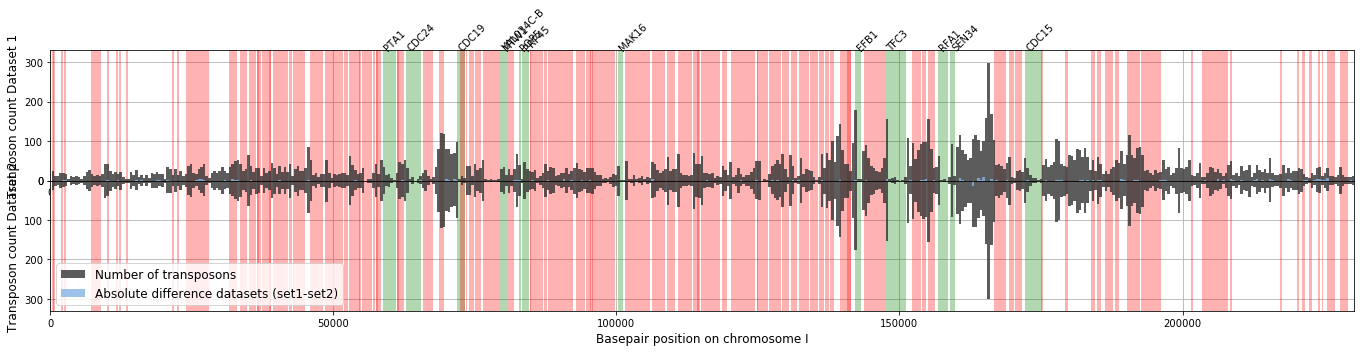

In [8]:
#LOOP OVER CHROMOSOMES
for chrom in chrom_list:
    print('')
    print('Analyzing chromosome: ', chrom)
    genes_currentchrom_pos_list = [k for k, v in gene_pos_dict.items() if chrom in v]

#LOOP OVER BED FILES
    allinsertionsites_allfiles_list = []
    alltransposoncounts_allfiles_binnedlist = []
    for bed_file in bed_files:
        with open(bed_file) as f:
            lines = f.readlines()

        chrom_start_index_dict, chrom_end_index_dict= chromosome_name_bedfile(lines)[1:3]

#CREATE LIST OF ALL TRANSPOSON COUNTS IN THE CURRENT CHROMOSOME
        alltransposoncounts_list = np.zeros(chr_length_dict.get(chrom)+2)
        for line in lines[chrom_start_index_dict.get(chrom):chrom_end_index_dict.get(chrom)+1]:
            line = line.strip('\n').split()
            alltransposoncounts_list[int(line[1])] += 1

#DETERMINE BINWIDTH
        if bar_width_user_set == None:
            bar_width = int(chr_length_dict.get(chrom)/500)
        else:
            bar_width = bar_width_user_set

#DIVIDE THE CHROMOSOME UP IN REGIONS WITH SIZE EQUAL TO THE BINWIDTH AND SUM UP ALL TRANSPOSON COUNTS WITHIN THE BIN
        alltransposoncounts_binnedlist = []
        val_counter = 0
        sum_values = 0
        if bar_width == 1:
            alltransposoncounts_binnedlist = alltransposoncounts_list
            allinsertionsites_list = np.linspace(0,chr_length_dict.get(chrom),int(chr_length_dict.get(chrom)/float(bar_width)))
        else:
            for n in range(len(alltransposoncounts_list)):
                if val_counter % bar_width != 0:
                    sum_values += alltransposoncounts_list[n]
                elif val_counter % bar_width == 0:
                    alltransposoncounts_binnedlist.append(sum_values)
                    sum_values = 0
                val_counter += 1
                
            allinsertionsites_list = np.linspace(0,chr_length_dict.get(chrom),int(chr_length_dict.get(chrom)/bar_width)+1)
    
        allinsertionsites_allfiles_list.append(allinsertionsites_list)
        alltransposoncounts_allfiles_binnedlist.append(alltransposoncounts_binnedlist)

#DETERMINE THE ABSOLUTE DIFFERENCE BETWEENT THE TRANSPOSON COUNTS IN THE DIFFERENT DATASETS
    transposoncounts_positivedifference_list = [0]*len(alltransposoncounts_allfiles_binnedlist[0])
    transposoncounts_negativedifference_list = [0]*len(alltransposoncounts_allfiles_binnedlist[0])
    for i in range(0,len(alltransposoncounts_allfiles_binnedlist[0])):
        difference = alltransposoncounts_allfiles_binnedlist[0][i]-alltransposoncounts_allfiles_binnedlist[1][i]
        if difference >= 0:
            transposoncounts_positivedifference_list[i] = difference
        elif difference < 0:
            transposoncounts_negativedifference_list[i] = -difference

#PLOTTING OF THE BARPLOT INCLUDING AN OVERLAY OF THE ABSOLUTE DIFFERENCE
    print('Plotting chromosome ', chrom, '...')
    print('bar width for plotting is ',bar_width)
    binsize = bar_width
    font_size = 12
    max_ylim = max([item for sublist in alltransposoncounts_allfiles_binnedlist for item in sublist]) #GET MAXIMUM VALUE FOR SETTING THE Y AXIS LIMIT EQUAL FOR BOTH GRAPHS
    max_ylim = max_ylim + 0.1*max_ylim
    
    
    plt.figure(figsize=(19,5))
    grid = plt.GridSpec(2, 1, wspace=0.0, hspace=0.0)


    ax1 = plt.subplot(grid[0,0])
    for gene in genes_currentchrom_pos_list:
        gene_start_pos = int(gene_pos_dict.get(gene)[1])
        gene_end_pos = int(gene_pos_dict.get(gene)[2])
        if gene in genes_essential_list:
            ax1.axvspan(gene_start_pos,gene_end_pos,facecolor='g',alpha=0.3)
            ax1.text(gene_start_pos,max_ylim,gene_alias_list.get(gene)[0], rotation=45)
        else:
            ax1.axvspan(gene_start_pos,gene_end_pos,facecolor='r',alpha=0.3)

    ax1.bar(allinsertionsites_allfiles_list[0],alltransposoncounts_allfiles_binnedlist[0],width=binsize,color=(0.2,0.2,0.2,0.8))
    ax1.bar(allinsertionsites_allfiles_list[0],transposoncounts_positivedifference_list,width=binsize,color=(0.52,0.71,0.90,0.8))

    ax1.set_axisbelow(True)
    ax1.grid(True)
    ax1.set_ylabel('Tranposon count Dataset 1', fontsize=font_size)
    ax1.set_xlim(0,chr_length_dict.get(chrom))
    ax1.set_ylim(0,max_ylim)


    ax2 = plt.subplot(grid[1,0])
    for gene in genes_currentchrom_pos_list:
        gene_start_pos = int(gene_pos_dict.get(gene)[1])
        gene_end_pos = int(gene_pos_dict.get(gene)[2])
        if gene in genes_essential_list:
            ax2.axvspan(gene_start_pos,gene_end_pos,facecolor='g',alpha=0.3)
        else:
            ax2.axvspan(gene_start_pos,gene_end_pos,facecolor='r',alpha=0.3)

    ax2.bar(allinsertionsites_allfiles_list[1],alltransposoncounts_allfiles_binnedlist[1],width=binsize,color=(0.2,0.2,0.2,0.8), label='Number of transposons')
    ax2.bar(allinsertionsites_allfiles_list[1],transposoncounts_negativedifference_list,width=binsize,color=(0.52,0.71,0.90,0.8), label='Absolute difference datasets (set1-set2)')

    ax2.set_axisbelow(True)
    ax2.grid(True)
    ax2.set_ylabel('Transposon count Dataset 2', fontsize=font_size)
    ax2.set_xlabel('Basepair position on chromosome '+chrom, fontsize=font_size)
    ax2.set_ylim(0,max_ylim)
    ax2.set_xlim(0,chr_length_dict.get(chrom))
    ax2.invert_yaxis()
    ax2.legend(loc='lower left', fontsize=font_size)
    
    plt.tight_layout()
    
    if savefigure_path is not None and savefigure_name is not None:
        saving_name = os.path.join(savefigure_path,'Chrom'+chrom+'_'+savefigure_name)
        plt.savefig(saving_name)
        if chrom_user_set is None:
            plt.close()

## The python script for comparing number of reads

This function creates a bar plot with the number of reads in a chromosome. The background of the bar plot has colored regions that indicate the locations of the genes. Green regions indicate annotated essential genes and red regions are the genes not annotated as essential. The names of the essential genes are given as well.

This graph can be used to check how well the reads corresponds with the location of essential genes, where only few transposon insertions are expected, which can be directly compared between two datasets.

The code for the reads is somewhat similar to that for the transposons profile plot.
Import the same packages that are given above.

In [9]:
wig_files = [os.path.join(file_dirname,'..','satay_analysis_testdata','Output_Processing','Cerevisiae_WT2_Michel2017_trimmed1.bam.wig'),
os.path.join(file_dirname,'..','satay_analysis_testdata','Output_Processing','Cerevisiae_WT2_Michel2017_trimmed2.bam.wig')] #CHANGE THIS TO ANY .WIG FILES YOU WANT TO ANALYSE.
chrom_user_set = 'I'
bar_width_user_set=None
savefigure_path=None
savefigure_name=None

### Loading additional files

In [10]:
gff_file = os.path.join(file_dirname,'Data_Files','Saccharomyces_cerevisiae.R64-1-1.99.gff3')
essential_genes_files = [os.path.join(file_dirname,'Data_Files','Cervisiae_EssentialGenes_List_1.txt'),
                        os.path.join(file_dirname,'Data_Files','Cervisiae_EssentialGenes_List_2.txt')]
gene_information_file = os.path.join(file_dirname,'Data_Files','Yeast_Protein_Names.txt')

### Get chromosome length and essential genes

Determine the length and position of all chromosomes and get a list of all genes, all essential genes and the aliases of all the genes.

In [11]:
chr_length_dict, chr_start_pos_dict, chr_end_pos_dict = chromosome_position(gff_file)

gene_pos_dict = gene_position(gff_file)
genes_essential_list = list_known_essentials(essential_genes_files)
gene_alias_list = gene_aliases(gene_information_file)[0]    

Reading file : c:\Users\linigodelacruz\Documents\PhD_2018\Documentation\SATAY\LaanLab-SATAY-DataAnalysis\Python_scripts\Data_Files\Cervisiae_EssentialGenes_List_1.txt
Reading file : c:\Users\linigodelacruz\Documents\PhD_2018\Documentation\SATAY\LaanLab-SATAY-DataAnalysis\Python_scripts\Data_Files\Cervisiae_EssentialGenes_List_2.txt


### Determine which chromosome(s) needs to be analyzed.

The input for the `chrom_user_set` is either a string containing a single roman numeral representing the chromsome to be analyzed, a list of roman numerals for multiple chromosomes to analyze or None, in which case all the chromsomes are analyzed.
The next code determines what is put in and what has to be done.

In [13]:
if type(chrom_user_set) is list:
    chrom_list = chrom_user_set
elif type(chrom_user_set) is str:
    chrom_list = [chrom_user_set.upper()]
else:
    chrom_list = []
    roman_to_arabic_numerals = chromosomename_roman_to_arabic()[1]
    for keys in roman_to_arabic_numerals:
        chrom_list.append(keys)

### Determine number of reads for each chromsome in each of the two datasets

First loop over all chromosomes.
Within this loop, a second loop is implemented that loops over both datasets.
For each chromosome, determine the number of reads (saved in the variable `allreadscounts_list`).
The chromosome is then divided in equally sized regions that later become the different bins in the barplot.
In each bin, the reads are summed up.
For each chromosome the absolute differences are determined between the datasets.
Finally, each chromosome is plotted and saved if required.


Analyzing chromosome:  I
Plotting chromosome  I ...
bar width for plotting is  460


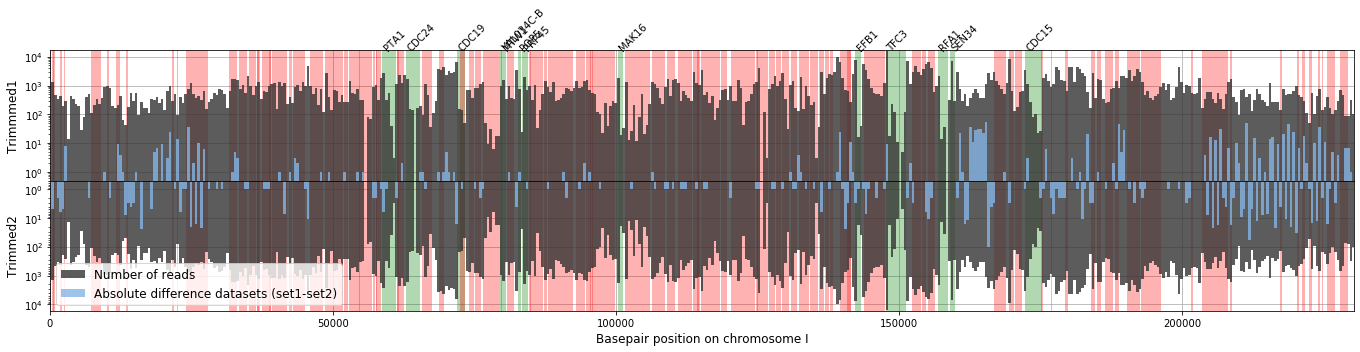

In [14]:
#LOOP OVER ALL CHROMOSOMES
for chrom in chrom_list:
    print('')
    print('Analyzing chromosome: ', chrom)
    genes_currentchrom_pos_list = [k for k, v in gene_pos_dict.items() if chrom in v]
    
#READ WIG FILE
    allinsertionsites_allfiles_list = []
    allreadscounts_allfiles_binnedlist = []
    for wig_file in wig_files:
        with open(wig_file) as f:
            lines = f.readlines()

#GET THE NAMES OF THE CHROMOSOMES AS USED IN THE WIG FILE
        chrom_names_dict, chrom_start_line_dict, chrom_end_line_dict = chromosome_name_wigfile(lines)

#GET ALL LINES WITH THE READS FOR THE CURRENT CHROMOSOME
        wigfile_start_index = chrom_start_line_dict.get(chrom)
        wigfile_end_index = chrom_end_line_dict.get(chrom)

#DETERMINE THE NUMBER OF READS OF ALL POSSIBLE INSERTION SITES IN THE CHROMOSOME
        allreadscounts_list = np.zeros(chr_length_dict.get(chrom)+2)
        for line in lines[wigfile_start_index:wigfile_end_index]:
            line = line.strip(' \n').split()
            allreadscounts_list[int(line[0])] = int(line[1])

#BINNING OF THE INSERTION SITES FOR TO SPEED UP THE PLOTTING PROCESS
        if bar_width_user_set == None:
            bar_width = int(chr_length_dict.get(chrom)/500)
        else:
            bar_width = bar_width_user_set

        allreadscounts_binnedlist = []
        val_counter = 0
        sum_values = 0
        if bar_width == 1:
            allreadscounts_binnedlist = allreadscounts_list
            allinsertionsites_list = np.linspace(0,chr_length_dict.get(chrom),int(chr_length_dict.get(chrom)/float(bar_width)))
        else:
            for n in range(len(allreadscounts_list)):
                if val_counter % bar_width != 0:
                    sum_values += allreadscounts_list[n]
                elif val_counter % bar_width == 0:
                    allreadscounts_binnedlist.append(sum_values)
                    sum_values = 0
                val_counter += 1
                
            allinsertionsites_list = np.linspace(0,chr_length_dict.get(chrom),int(chr_length_dict.get(chrom)/bar_width)+1)

        allinsertionsites_allfiles_list.append(allinsertionsites_list)
        allreadscounts_allfiles_binnedlist.append(allreadscounts_binnedlist)

#DETERMINE ABSOLUTE DIFFERENCE BETWEEN DATASETS TRANSPOSONCOUNTS
    readcounts_positivedifference_list = [0]*len(allreadscounts_allfiles_binnedlist[0])
    readcounts_negativedifference_list = [0]*len(allreadscounts_allfiles_binnedlist[0])
    for i in range(0,len(allreadscounts_allfiles_binnedlist[0])):
        difference = allreadscounts_allfiles_binnedlist[0][i]-allreadscounts_allfiles_binnedlist[1][i]
        if difference >= 0:
            readcounts_positivedifference_list[i] = difference
        elif difference < 0:
            readcounts_negativedifference_list[i] = -difference

#PLOTTING
    print('Plotting chromosome ', chrom, '...')
    print('bar width for plotting is ',bar_width)
    binsize = bar_width
    font_size = 12
    max_ylim = max([item for sublist in allreadscounts_allfiles_binnedlist for item in sublist])
    max_ylim = max_ylim + 0.1*max_ylim
    
    plt.figure(figsize=(19,5))
    grid = plt.GridSpec(2, 1, wspace=0.0, hspace=0.0)


    ax1 = plt.subplot(grid[0,0])
    for gene in genes_currentchrom_pos_list:
        gene_start_pos = int(gene_pos_dict.get(gene)[1])
        gene_end_pos = int(gene_pos_dict.get(gene)[2])
        if gene in genes_essential_list:
            ax1.axvspan(gene_start_pos,gene_end_pos,facecolor='g',alpha=0.3)
            ax1.text(gene_start_pos,max_ylim,gene_alias_list.get(gene)[0], rotation=45)
        else:
            ax1.axvspan(gene_start_pos,gene_end_pos,facecolor='r',alpha=0.3)
    
    ax1.bar(allinsertionsites_allfiles_list[0],allreadscounts_allfiles_binnedlist[0],width=binsize,color=[0.2,0.2,0.2,0.8])
    ax1.bar(allinsertionsites_allfiles_list[0],readcounts_positivedifference_list,width=binsize,color=(0.52,0.71,0.90,0.8))

    ax1.set_yscale('log')
    ax1.set_axisbelow(True)
    ax1.grid(True)
    ax1.set_ylabel('Trimmmed1', fontsize=font_size)#('Read count (log_10) Dataset 1', fontsize=font_size)
    ax1.set_xticklabels([])
    ax1.set_xlim(0,chr_length_dict.get(chrom))
    ax1.set_ylim(0.5,max_ylim)


    ax2 = plt.subplot(grid[1,0])
    for gene in genes_currentchrom_pos_list:
        gene_start_pos = int(gene_pos_dict.get(gene)[1])
        gene_end_pos = int(gene_pos_dict.get(gene)[2])
        if gene in genes_essential_list:
            ax2.axvspan(gene_start_pos,gene_end_pos,facecolor='g',alpha=0.3)
        else:
            ax2.axvspan(gene_start_pos,gene_end_pos,facecolor='r',alpha=0.3)
    
    ax2.bar(allinsertionsites_allfiles_list[1],allreadscounts_allfiles_binnedlist[1],width=binsize,color=[0.2,0.2,0.2,0.8], label='Number of reads')
    ax2.bar(allinsertionsites_allfiles_list[1],readcounts_negativedifference_list,width=binsize,color=(0.52,0.71,0.90,0.8), label='Absolute difference datasets (set1-set2)')

    ax2.set_yscale('log')
    ax2.set_axisbelow(True)
    ax2.grid(True)
    ax2.set_ylabel('Trimmed2', fontsize=font_size)#('Read count (log_10) Dataset 2', fontsize=font_size)
    ax2.set_xlabel('Basepair position on chromosome '+chrom, fontsize=font_size)
    ax2.set_xlim(0,chr_length_dict.get(chrom))
    ax2.set_ylim(0.5,max_ylim)
    ax2.invert_yaxis()
    ax2.legend(loc='lower left', fontsize=font_size)
    
    plt.tight_layout()
    
    if savefigure_path is not None and savefigure_name is not None:
        saving_name = os.path.join(savefigure_path,'Chrom'+chrom+'_'+savefigure_name)
        plt.savefig(saving_name)
        if chrom_user_set is None:
            plt.close()

## Interpretation

The bar plots indicate areas of high and low insertion densities and how many reads the transposons in each region have.
Ideally the essential regions should be free of transposons and/or have few reads. The other parts of the chromosome should then have transposon insertions combined with relatively many reads. However, it might occur that transposons are present in the essential regions or that regions not annotated as essential have little or no insertions, as is discussed in the paper by Michel et.al. 2017. Also it is also not always clear which genes are essential or not. Sometimes genes are assigned essential by one study, but not by another, hence its essentiality might be dubious.

The graphs show the transposon and read count for two datasets which are represented by the upward and downward pointing bars.
The absolute difference between the datasets are indicated by the blue bars.
This can help identifying if there are regions that are more likely to have differences than other regions which can help in optimizing the preprocessing steps.

## Bibliography
- Michel, A. H., Hatakeyama, R., Kimmig, P., Arter, M., Peter, M., Matos, J., ... & Kornmann, B. (2017). Functional mapping of yeast genomes by saturated transposition. Elife, 6, e23570.
- Segal, E. S., Gritsenko, V., Levitan, A., Yadav, B., Dror, N., Steenwyk, J. L., ... & Kunze, R. (2018). Gene essentiality analyzed by in vivo transposon mutagenesis and machine learning in a stable haploid isolate of Candida albicans. MBio, 9(5), e02048-18.